In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar
from scipy import integrate,special

In [2]:
#Define the constants
main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 8.
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(N=1,I=0.5,B=15496.8125/Gamma,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,gI=5.585,gS=2.0023193043622,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(J=0.5,I=0.5,
    P=+1,B=15788.2/Gamma,D=0.,H=0.,a=0./Gamma,b=-0.4/Gamma,c=0.,q=0., p=15./Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [3]:
def Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    pX = (p1+p2+p3+p4)/4
    pp1 = p1 - pX
    pp2 = p2 - pX
    pp3 = p3- pX
    pp4 = p4 - pX
    
    def intensity_res(pp):
        intensity_norm = 0.050
        result = 2.*(intensity_norm+pp/(10**3))/(np.pi*(0.012)**2)/Isat
        return result
    
    def sigmoid_function(x):
        if (1/(1+np.exp(-1*x))*2)//1 == 1.:
            return +1
        else:
            return -11
    
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp1), delta=(E_A[-1] - Eg_i)+d1,pol=sigmoid_function(pol1),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp2), delta=(E_A[-1] - Eg_i)+d2,pol=sigmoid_function(pol2),wb=waist,
                beam_type=pylcp.gaussianBeam)
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp3), delta=(E_A[-1] - Eg_i)+d3,pol=sigmoid_function(pol3),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp4), delta=(E_A[-1] - Eg_i)+d4,pol=sigmoid_function(pol4),wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [4]:
def vc_bayesian(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def Coil_field(Bgrads,R):
        Bx = -1/4.4415*Bgrads*R[0]*x0*1000
        By = -1/4.4415*Bgrads*R[1]*x0*1000
        Bz = Bgrads*R[2]*x0
        return np.array([Bx,By,Bz])


#     def trap_condition(t,y):
#         if abs(y[-6])*1000*x0<10 and abs(y[-4])*1000*x0<10 and abs(y[-3])<5e-2 and abs(y[-1])<5e-2:
#             val = -1.
#         else:
#             val = 1.
#         return val
    
#     def lost_condition(t,y):
#         if y[-6]*1000*x0>30 or abs(y[-4])*1000*x0>10:
#             val = -1.
#         else:
#             val=1.
#         return val
    
#     trap_condition.terminal = True
#     lost_condition.terminal = True
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = lambda R,t : Coil_field(Bgrad,R)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0s,v0s,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    if abs(sol.r[0][-1])*1000*x0<10 and abs(sol.v[0][-1])<5e-2:
        return v0s
    else:
        return -1.

In [11]:
start = time.time()

print(vc_bayesian(2.5,1.252,-0.4,0.1,-1.7,-2.8,5,21,28,26,-1,-1,1,-1))  

print(time.time()-start)

2.5
8.855360269546509


In [5]:
pbounds = {'v0s':(2,8),'Bgrad':(0.5,20),'d1':(-3,1),'d2':(-3,1),'d3':(-3,1),'d4':(-3,1),'p1':(0,50),'p2':(0,50),'p3':(0,50),'p4':(0,50),'pol1':(-1,1),'pol2':(-1,1),'pol3':(-1,1),'pol4':(-1,1)}

In [6]:
optimizer = BayesianOptimization(
    f = vc_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [14]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.0      |  8.632    | -0.1187   | -3.0      | -1.791    | -2.413    |  4.617    |  9.313    |  17.28    |  19.84    |  0.07763  | -0.1616   |  0.3704   | -0.5911   |  7.269    |
|  2        |  2.657    |  8.159    | -0.5539   | -0.8439   | -2.181    | -2.332    |  24.15    |  28.56    |  2.302    |  30.67    | -0.5294   | -0.2846   |  0.7505   |  0.5304   |  2.657    |
43.229613065719604


In [7]:
from bayes_opt.util import load_logs

# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["./logs_update.json"])

In [8]:
optimizer.max

{'target': 5.761614983061673,
 'params': {'Bgrad': 2.5292051720695046,
  'd1': -2.342005526929945,
  'd2': -0.6475705326556596,
  'd3': -2.1289507330733537,
  'd4': -0.16476307816457147,
  'p1': 16.478373418476938,
  'p2': 4.970983929588368,
  'p3': 40.023817831203324,
  'p4': 33.08779896059957,
  'pol1': -0.04335662246115479,
  'pol2': 0.3366592462685245,
  'pol3': 0.8740834907465769,
  'pol4': 0.19361922677925247,
  'v0s': 5.761614983061673}}

In [10]:
len(optimizer.res)

260

In [15]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_update.json')
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [17]:
start = time.time()
optimizer.maximize(
    init_points=30,
    n_iter=100,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  133      | -1.0      |  16.16    | -1.39     |  0.6187   | -2.852    |  0.0955   |  6.282    |  30.93    |  0.5182   |  26.93    | -0.994    |  0.9024   |  0.8108   |  0.5919   |  7.492    |
|  134      | -1.0      |  3.338    | -2.369    | -2.249    | -0.51     |  0.6232   |  49.5     |  35.56    |  36.59    |  45.46    | -0.1983   | -0.5003   | -0.6531   | -0.7611   |  6.876    |
|  135      | -1.0      |  3.362    | -1.943    |  0.2764   | -1.758    |  0.9297   |  13.33    |  26.68    |  15.72    |  45.54    | -0.2669   | -0.1328   |  0.02459  |  0.8778   |  2.186    |
|  136      | -1.0      |  14.

In [ ]:
import pprint

In [ ]:
pprint.pprint(optimizer.max)

In [ ]:
optimizer.res[0]

In [17]:
# vc_bayesian(**optimizer.max['params'])

In [18]:
def ploting_function(v0s,I, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def Coil_field(I,R:np.array):
        n = 510
        s = 0.1016 # in meter
        rad = 0.071976 # in meter
        def dBx(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            # print(dl,rprime,dB)
            return dB[0]
        def dBy(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[1]

        def dBz(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[2]


        Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
        By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
        Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]

        return np.array([Bx,By,Bz])*n*10000 # Return in Gauss
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=lambda R,t:Coil_field(I,R)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,0,0]),np.array([v0s,0,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA')
    
    fig,ax = plt.subplots(1,1,figsize=(13,7))
    
    imz = ax.imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax)
    cbz.set_label('$a (\mathrm{km/s^2})$')
    ax.set_xlabel('$x (\mathrm{mm})$')
    ax.set_ylabel('$v (\mathrm{m/s})$')
    ax.set_title('X axis force image')
    ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    ax.plot(eqn.sol.r[0]*x0*1000,eqn.sol.v[0]*v0,'k') 
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/optimized')
    

In [21]:
def ploting_function_2(v0s,I, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def Coil_field(I,R:np.array):
        n = 510
        s = 0.1016 # in meter
        rad = 0.071976 # in meter
        def dBx(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            # print(dl,rprime,dB)
            return dB[0]
        def dBy(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[1]

        def dBz(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[2]


        Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
        By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
        Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]

        return np.array([Bx,By,Bz])*n*10000 # Return in Gauss
    v_list = np.linspace(v0s-2,v0s+2,11)
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    sols_list = list()
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=lambda R,t:Coil_field(I,R)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
#     eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
#     eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
#     eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)


    
    for v0ss in v_list:
        eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0ss,v0ss,1]))
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

        eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 1,method='LSODA',max_step = 2e5)
        sols_list.append(eqn.sol)
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    
#     imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
#            extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
#                    np.amin(vv*v0), np.amax(vv*v0)),
#            aspect='auto',cmap='RdBu')
#     cbx = plt.colorbar(imx,ax = ax[0])
#     cbx.set_label('$a (\mathrm{km/s^2})$')
    
#     imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
#            extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
#                    np.amin(vv*v0), np.amax(vv*v0)),
#            aspect='auto',cmap='RdBu')
#     cby = plt.colorbar(imy,ax = ax[1])
#     cby.set_label('$a (\mathrm{km/s^2})$')

#     imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
#            extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
#                    np.amin(vv*v0), np.amax(vv*v0)),
#            aspect='auto',cmap='RdBu')
#     cbz = plt.colorbar(imz,ax = ax[2])
#     cbz.set_label('$a (\mathrm{km/s^2})$')
    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*v_max*v0,1*v_max*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    for sol in sols_list:
        ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0)
        ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0)
        ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0)
        print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
#     fig.savefig('./MOT/optimized_xy')
    

Completed in 44.60 s.                                                    
Completed in 1:40.                                                       
Completed in 1:12.                                                       
Completed in 42.28 s.                                                    
Completed in 38.04 s.                                                    
Completed in 26.02 s.                                                    
Completed in 30.27 s.                                                    
Completed in 36.01 s.                                                    
Completed in 41.39 s.                                                    
Completed in 30.47 s.                                                    
Completed in 36.45 s.                                                    
7.816533630112002 20620940.171011426
30.12088576222311 30.12088576222311
33.282725762223116 33.282725762223116
36.444565762223114 36.444565762223114
39.60640576222311 39.60640576222311
4

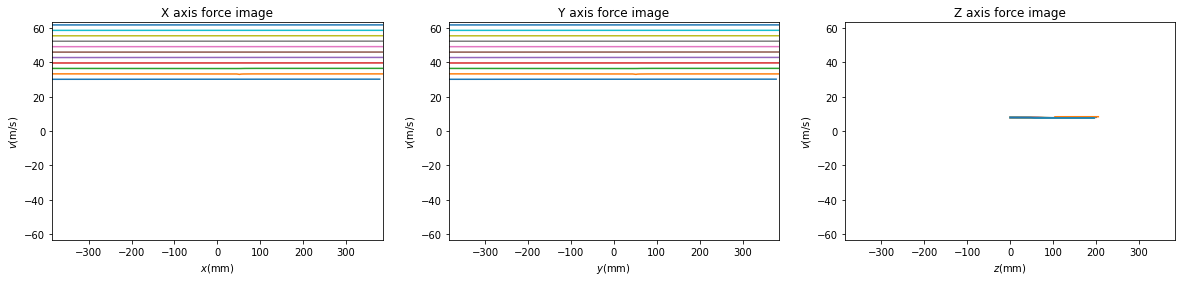

In [22]:
ploting_function_2(**optimizer.max['params'])

In [17]:
optimizer.max['params']

{'I': 12.528168984164047,
 'd1': -2.5199775899908197,
 'd2': 0.22773582325913377,
 'd3': -0.6681841482979487,
 'd4': -0.4729265546420556,
 'p1': 15.499490198498794,
 'p2': 20.486544283932638,
 'p3': 23.168825254769747,
 'p4': 21.018278114257004,
 'pol1': -0.7070729036856251,
 'pol2': -0.22622612784360263,
 'pol3': 0.8451169581057016,
 'pol4': 0.9480729825079086,
 'v0s': 5.810551547481607}

In [ ]:
3e6*t0

In [ ]:
1e5*x0